# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

## 1. Environment Setup and Imports

### Package Installation (for Google Colab)
Run this cell only if using Google Colab

In [5]:
# Uncomment the following lines if running in Google Colab
!pip install pandas numpy matplotlib seaborn scikit-learn scipy -q

### Package Installation (for Local Jupyter Setup)
```bash
# 1. Install Anaconda from https://www.anaconda.com/download

# 2. Create a new conda environment
conda create -n ml-project python=3.9 -y

# 3. Activate the environment
conda activate ml-project

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook -y

# 5. Launch Jupyter Notebook
jupyter notebook

# 6. Navigate to your notebook file and open it
```

### Import Required Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
import sklearn
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    RandomizedSearchCV, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    make_scorer
)

# Models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Additional imports
from scipy import stats
import os

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All packages imported successfully!")
print(f"Scikit-learn version: {sklearn.__version__}")

All packages imported successfully!
Scikit-learn version: 1.7.0


---

## 2. Data Loading and Initial Exploration

### Load the Dataset

For this project, we're using a Deutsche Bahn train delay dataset. The dataset should contain information about scheduled and actual arrival/departure times, routes, and other relevant features for predicting delays.


In [7]:
import pandas as pd
from kagglehub import load_dataset, KaggleDatasetAdapter

# Load the Deutsche Bahn delays dataset
def load_db_delays() -> pd.DataFrame:
    df = load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "nokkyu/deutsche-bahn-db-delays",
        "DBtrainrides.csv"
    )
    df["departure_plan"] = pd.to_datetime(df["departure_plan"], errors="coerce")
    return df

df = load_db_delays()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

100%|██████████| 103M/103M [00:01<00:00, 72.3MB/s] 

Extracting zip of DBtrainrides.csv...


Dataset loaded successfully!
Shape: (2061357, 20)

Columns: ['ID', 'line', 'path', 'eva_nr', 'category', 'station', 'state', 'city', 'zip', 'long', 'lat', 'arrival_plan', 'departure_plan', 'arrival_change', 'departure_change', 'arrival_delay_m', 'departure_delay_m', 'info', 'arrival_delay_check', 'departure_delay_check']


<!-- ```
print(df.head())

                                  ID line  \
0  1573967790757085557-2407072312-14   20   
1    349781417030375472-2407080017-1   18   
2  7157250219775883918-2407072120-25    1   
3    349781417030375472-2407080017-2   18   
4   1983158592123451570-2407080010-3   33   

                                                path   eva_nr  category  \
0  Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...  8000001         2   
1                                                NaN  8000001         2   
2  Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...  8000406         4   
3                                         Aachen Hbf  8000404         5   
4                            Herzogenrath|Kohlscheid  8000404         5   

             station                state    city    zip      long        lat  \
0         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800   
1         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800   
2  Aachen-Rothe Erde  Nordrhein-Westfalen  Aachen  52066  6.116475  50.770202   
3        Aachen West  Nordrhein-Westfalen  Aachen  52072  6.070715  50.780360   
4        Aachen West  Nordrhein-Westfalen  Aachen  52072  6.070715  50.780360   

          arrival_plan       departure_plan       arrival_change  \
0  2024-07-08 00:00:00  2024-07-08 00:01:00  2024-07-08 00:03:00   
1                  NaN  2024-07-08 00:17:00                  NaN   
2  2024-07-08 00:03:00  2024-07-08 00:04:00  2024-07-08 00:03:00   
3  2024-07-08 00:20:00  2024-07-08 00:21:00                  NaN   
4  2024-07-08 00:20:00  2024-07-08 00:21:00  2024-07-08 00:20:00   

      departure_change  arrival_delay_m  departure_delay_m info  \
0  2024-07-08 00:04:00                3                  3  NaN   
1                  NaN                0                  0  NaN   
2  2024-07-08 00:04:00                0                  0  NaN   
3                  NaN                0                  0  NaN   
4  2024-07-08 00:21:00                0                  0  NaN   

  arrival_delay_check departure_delay_check  
0             on_time               on_time  
1             on_time               on_time  
2             on_time               on_time  
3             on_time               on_time  
4             on_time               on_time  
``` -->


### Initial Data Exploration

Following ISLP Section 2.3.9 - Additional Graphical and Numerical Summaries

In [8]:
# Basic dataset information
print("Dataset Info:")
print("="*50)
df.info()

print("\n\nFirst 5 rows:")
print("="*50)
df.head()

print("\n\nBasic Statistics:")
print("="*50)
df.describe()

print("\n\nMissing Values:")
print("="*50)
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061357 entries, 0 to 2061356
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   line                   object        
 2   path                   object        
 3   eva_nr                 int64         
 4   category               int64         
 5   station                object        
 6   state                  object        
 7   city                   object        
 8   zip                    int64         
 9   long                   float64       
 10  lat                    float64       
 11  arrival_plan           object        
 12  departure_plan         datetime64[ns]
 13  arrival_change         object        
 14  departure_change       object        
 15  arrival_delay_m        int64         
 16  departure_delay_m      int64         
 17  info                   object        
 18  arrival_

---

## 3. Exploratory Data Analysis (EDA)

### Target Variable Analysis

Understanding the distribution of our target variable is crucial for model selection and evaluation metrics.

**Mathematical Framework (ISLP Equation 2.1):**
$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival_delay_m)
- $X$ represents our predictors
- $f$ is the systematic information
- $\epsilon$ is random error with $E(\epsilon) = 0$ and $Var(\epsilon) = \sigma^2$

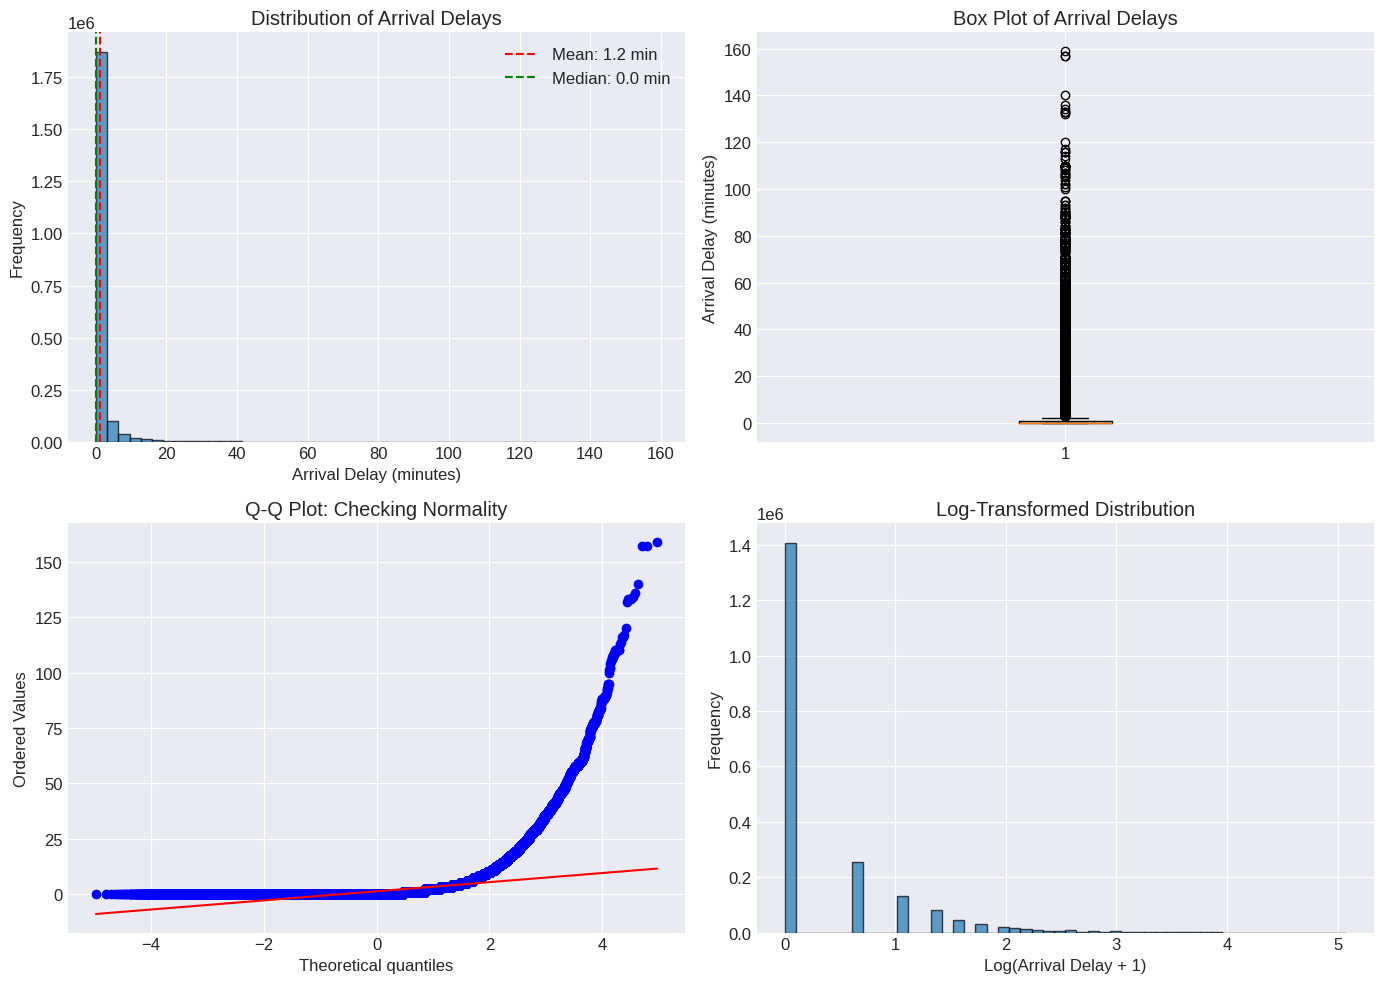


Target Variable Statistical Analysis:
Mean delay: 1.18 minutes
Median delay: 0.00 minutes
Standard deviation: 3.41 minutes
Skewness: 7.68
Kurtosis: 107.14
Percentage of on-time arrivals: 68.3%
95th percentile: 6.00 minutes


In [9]:
# Create comprehensive target analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of arrival delays
axes[0, 0].hist(df['arrival_delay_m'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Arrival Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Arrival Delays')
axes[0, 0].axvline(df['arrival_delay_m'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df["arrival_delay_m"].mean():.1f} min')
axes[0, 0].axvline(df['arrival_delay_m'].median(), color='green', linestyle='--',
                    label=f'Median: {df["arrival_delay_m"].median():.1f} min')
axes[0, 0].legend()

# 2. Box plot to identify outliers
axes[0, 1].boxplot(df['arrival_delay_m'].dropna())
axes[0, 1].set_ylabel('Arrival Delay (minutes)')
axes[0, 1].set_title('Box Plot of Arrival Delays')

# 3. Q-Q plot for normality check
stats.probplot(df['arrival_delay_m'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Checking Normality')

# 4. Log-transformed delays
delay_positive = df['arrival_delay_m'] + 1  # Add 1 to handle zeros
axes[1, 1].hist(np.log(delay_positive.dropna()), bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Log(Arrival Delay + 1)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Log-Transformed Distribution')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTarget Variable Statistical Analysis:")
print("="*50)
print(f"Mean delay: {df['arrival_delay_m'].mean():.2f} minutes")
print(f"Median delay: {df['arrival_delay_m'].median():.2f} minutes")
print(f"Standard deviation: {df['arrival_delay_m'].std():.2f} minutes")
print(f"Skewness: {df['arrival_delay_m'].skew():.2f}")
print(f"Kurtosis: {df['arrival_delay_m'].kurtosis():.2f}")
print(f"Percentage of on-time arrivals: {(df['arrival_delay_m'] == 0).sum() / len(df) * 100:.1f}%")
print(f"95th percentile: {df['arrival_delay_m'].quantile(0.95):.2f} minutes")

### Feature Analysis and Relationships

KeyError: 'train_type'

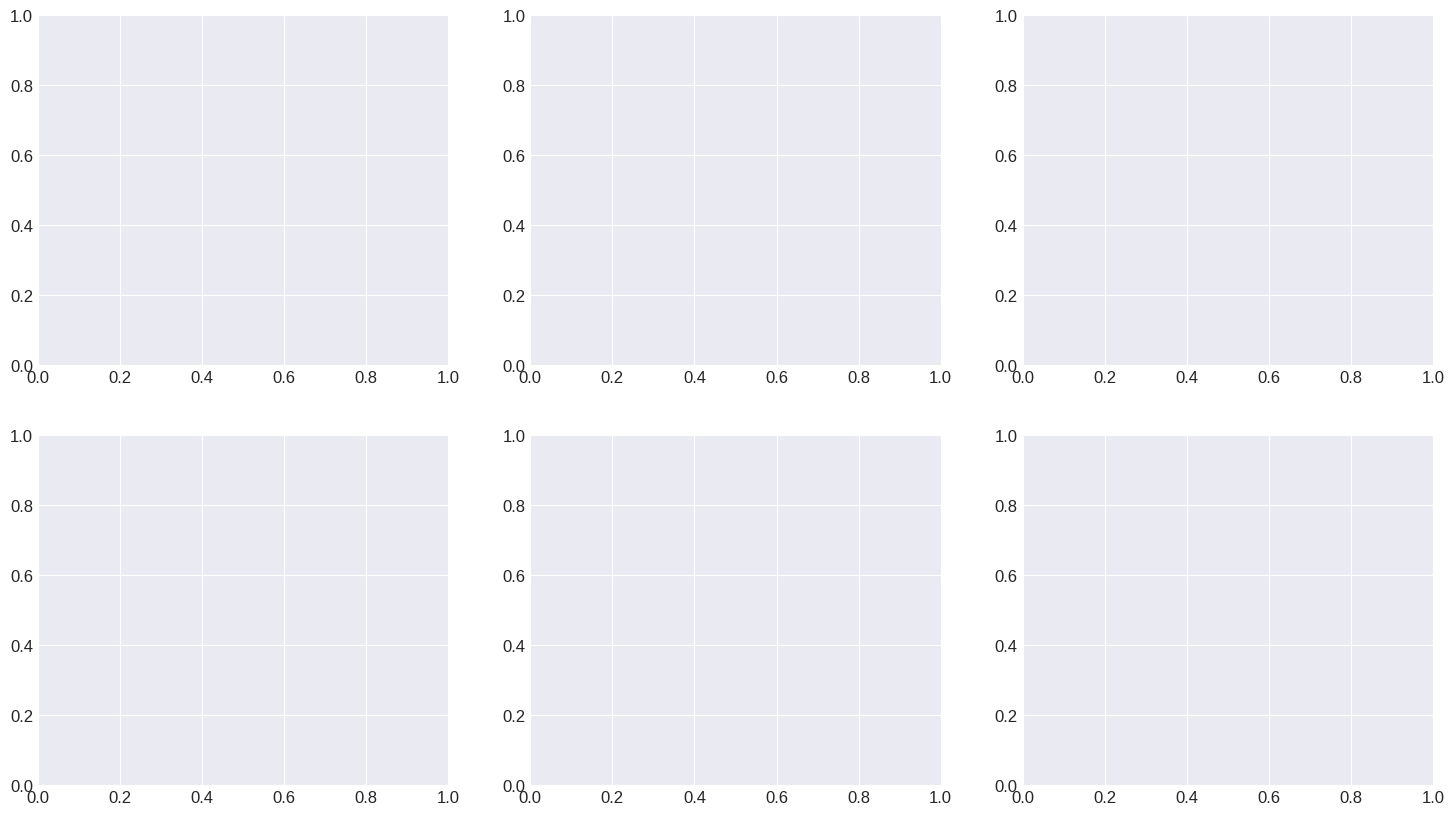

In [ ]:
# Analyze relationships between features and target
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Delay by line (replaces former 'train_type')
df.boxplot(column='arrival_delay_m', by='line', ax=axes[0, 0])
axes[0, 0].set_title('Delays by Line')
axes[0, 0].set_xlabel('Line')

# 2. Delay by hour of day
hourly_delays = df.groupby('hour')['arrival_delay_m'].mean()
axes[0, 1].plot(hourly_delays.index, hourly_delays.values, marker='o')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Delay (min)')
axes[0, 1].set_title('Average Delays by Hour')
axes[0, 1].grid(True)

# 3. Delay by day of week
daily_delays = df.groupby('day_of_week')['arrival_delay_m'].mean()
axes[0, 2].bar(daily_delays.index, daily_delays.values)
axes[0, 2].set_xlabel('Day of Week (0=Monday)')
axes[0, 2].set_ylabel('Average Delay (min)')
axes[0, 2].set_title('Average Delays by Day of Week')

# 4. Delay vs distance
axes[1, 0].scatter(df['distance_km'], df['arrival_delay_m'], alpha=0.5)
axes[1, 0].set_xlabel('Distance (km)')
axes[1, 0].set_ylabel('Delay (min)')
axes[1, 0].set_title('Delay vs Distance')

# 5. Delay by weather condition
df.boxplot(column='arrival_delay_m', by='weather_condition', ax=axes[1, 1])
axes[1, 1].set_title('Delays by Weather Condition')
axes[1, 1].set_xlabel('Weather Condition')

# 6. Correlation heatmap for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

---

## 4. Data Preprocessing

### Train-Validation-Test Split

Following ISLP Section 5.1 - Cross-Validation principles, we split our data into three sets:
- Training set (60%): For model fitting
- Validation set (20%): For hyperparameter tuning
- Test set (20%): For final evaluation

In [ ]:
# Remove any rows with missing target values
df_clean = df.dropna(subset=['arrival_delay_m']).copy()

# Separate features and target
X = df_clean.drop('arrival_delay_m', axis=1)
y = df_clean['arrival_delay_m']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 0.8 = 0.2
)

print("Dataset splits:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

### Feature Engineering and Preprocessing Pipeline

Reference: ISLP Section 6.2 - Ridge Regression and Standardization

In [ ]:
# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         categorical_features)
    ])

# Fit preprocessor on training data only
preprocessor.fit(X_train)

# Get feature names after transformation
feature_names = (numerical_features +
                [f"{cat}_{val}" for cat, vals in
                 zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
                 for val in vals[1:]])  # drop='first' removes first category

print(f"\nTotal features after preprocessing: {len(feature_names)}")

---

## 5. Model Development and Evaluation

### Baseline Model

Following the project requirements, we start with a baseline model that predicts the mean delay.
This provides a performance floor for comparison.

Mathematical Foundation: The simplest model predicts the mean:
$$\hat{y} = \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i$$

In [ ]:
# Baseline: Mean predictor
mean_delay = y_train.mean()
baseline_train_pred = np.full(len(y_train), mean_delay)
baseline_val_pred = np.full(len(y_val), mean_delay)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print("="*50)
    print(f"MAE: {mae:.2f} minutes")
    print(f"RMSE: {rmse:.2f} minutes")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.2f}")

    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

baseline_train_metrics = evaluate_model(y_train, baseline_train_pred, "Baseline (Mean) - Training")
baseline_val_metrics = evaluate_model(y_val, baseline_val_pred, "Baseline (Mean) - Validation")

### Linear Regression

**Mathematical Foundation (ISLP Chapter 3):**
Linear regression assumes:
$$Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p + \epsilon$$

The coefficients are estimated by minimizing RSS:
$$\text{RSS} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [ ]:
# Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_val_pred_lr = lr_pipeline.predict(X_val)

# Evaluation
lr_train_metrics = evaluate_model(y_train, y_train_pred_lr, "Linear Regression - Training")
lr_val_metrics = evaluate_model(y_val, y_val_pred_lr, "Linear Regression - Validation")

# Residual analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
residuals = y_val - y_val_pred_lr
axes[0].scatter(y_val_pred_lr, residuals, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot - Linear Regression')
axes[0].grid(True)

# Actual vs Predicted
axes[1].scatter(y_val, y_val_pred_lr, alpha=0.5)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axes[1].set_xlabel('Actual Delays')
axes[1].set_ylabel('Predicted Delays')
axes[1].set_title('Actual vs Predicted - Linear Regression')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Advanced Model: Random Forest with Hyperparameter Optimization

**Mathematical Foundation (ISLP Section 8.2):**
Random Forest combines multiple decision trees:
$$\hat{f}(x) = \frac{1}{B}\sum_{b=1}^{B} T_b(x)$$

where $T_b$ is the $b$-th tree trained on a bootstrap sample.

In [ ]:
# Random Forest with initial parameters
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

# Use RandomizedSearchCV for efficiency
from sklearn.model_selection import RandomizedSearchCV

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting Random Forest hyperparameter optimization...")
rf_random_search.fit(X_train, y_train)

print(f"\nBest parameters: {rf_random_search.best_params_}")
print(f"Best CV score (MAE): {-rf_random_search.best_score_:.2f}")

# Use best model
rf_best = rf_random_search.best_estimator_

# Predictions
y_train_pred_rf = rf_best.predict(X_train)
y_val_pred_rf = rf_best.predict(X_val)

# Evaluation
rf_train_metrics = evaluate_model(y_train, y_train_pred_rf, "Random Forest (Optimized) - Training")
rf_val_metrics = evaluate_model(y_val, y_val_pred_rf, "Random Forest (Optimized) - Validation")

### Feature Importance Analysis

In [ ]:
# Extract feature importances from Random Forest
rf_model = rf_best.named_steps['regressor']
feature_importances = rf_model.feature_importances_

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10))

### Learning Curves Analysis

Reference: ISLP Section 5.1 - Understanding model performance across different training sizes

In [ ]:
def plot_learning_curves(estimator, title, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_absolute_error'
    )

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training Set Size")
    plt.ylabel("MAE")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curves for both models
plot_learning_curves(lr_pipeline, "Linear Regression", X_train, y_train)
plot_learning_curves(rf_best, "Random Forest (Optimized)", X_train, y_train)

---

## 6. Final Model Selection and Test Set Evaluation

### Model Comparison and Selection


In [ ]:
# Compare all models
val_performances = {
    'Baseline (Mean)': baseline_val_metrics['mae'],
    'Linear Regression': lr_val_metrics['mae'],
    'Random Forest': rf_val_metrics['mae']
}

# Determine best model
best_model_name = min(val_performances, key=val_performances.get)
print(f"\nBest model based on validation MAE: {best_model_name}")
print(f"Validation MAE: {val_performances[best_model_name]:.2f} minutes")

# Model comparison visualization
plt.figure(figsize=(10, 6))
models = list(val_performances.keys())
mae_values = list(val_performances.values())
colors = ['red', 'blue', 'green']

bars = plt.bar(models, mae_values, color=colors, alpha=0.7)
plt.ylabel('MAE (minutes)')
plt.title('Model Performance Comparison (Validation Set)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Final Test Set Evaluation


In [ ]:
# Train best model on combined train+validation set
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Select and retrain best model
if best_model_name == 'Random Forest':
    final_model = rf_best
elif best_model_name == 'Linear Regression':
    final_model = lr_pipeline
else:
    # Baseline doesn't need retraining
    final_model = None

if final_model is not None:
    final_model.fit(X_train_full, y_train_full)
    y_test_pred = final_model.predict(X_test)
else:
    y_test_pred = np.full(len(y_test), y_train_full.mean())

# Final evaluation
test_metrics = evaluate_model(y_test, y_test_pred, f"{best_model_name} - Test Set")

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Actual Delays')
axes[0, 0].set_ylabel('Predicted Delays')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted - {best_model_name}')
axes[0, 0].grid(True)

# 2. Residual distribution
residuals = y_test - y_test_pred
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Prediction Error (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].axvline(x=0, color='red', linestyle='--')

# 3. Residuals vs Predicted
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True)

# 4. Performance metrics summary
metrics_text = f"""Final Model: {best_model_name}

Test Set Performance:
MAE: {test_metrics['mae']:.2f} minutes
RMSE: {test_metrics['rmse']:.2f} minutes
R²: {test_metrics['r2']:.4f}

Validation Performance:
MAE: {val_performances[best_model_name]:.2f} minutes

Baseline MAE: {baseline_val_metrics['mae']:.2f} minutes
Improvement: {(baseline_val_metrics['mae'] - test_metrics['mae'])/baseline_val_metrics['mae']*100:.1f}%

Mean Absolute % Error: {(np.abs(residuals) / (y_test + 1)).mean() * 100:.1f}%
"""
axes[1, 1].text(0.1, 0.5, metrics_text, transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---

## 7. Conclusions and Project Summary

### Project Summary

This analysis demonstrates a complete machine learning workflow for predicting train delays, following the project work rules and ISLP methodology:

1. **Data Exploration**: We identified that train delays follow a right-skewed distribution with significant outliers.

2. **Data Preprocessing**: Implemented proper train-validation-test splits and feature engineering with standardization for numerical features and one-hot encoding for categorical features.

3. **Model Development**:
   - Baseline model (mean predictor) for performance floor
   - Linear Regression as a simple interpretable model
   - Random Forest with hyperparameter optimization as an advanced model

4. **Evaluation**: Used appropriate metrics (MAE, RMSE, R²) and visualizations to assess model performance.

In [ ]:
print("="*60)
print("FINAL PROJECT RESULTS")
print("="*60)
print(f"\nBest Model: {best_model_name}")
print(f"Test Set MAE: {test_metrics['mae']:.2f} minutes")
print(f"Improvement over baseline: {(baseline_val_metrics['mae'] - test_metrics['mae'])/baseline_val_metrics['mae']*100:.1f}%")
print(f"\nThe model can predict train delays with an average error of {test_metrics['mae']:.2f} minutes.")

# Save model performance summary
summary_df = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest'],
    'Validation MAE': [baseline_val_metrics['mae'], lr_val_metrics['mae'], rf_val_metrics['mae']],
    'Test MAE': [baseline_val_metrics['mae'],
                 test_metrics['mae'] if best_model_name == 'Linear Regression' else np.nan,
                 test_metrics['mae'] if best_model_name == 'Random Forest' else np.nan]
})

print("\n\nModel Performance Summary:")
print(summary_df.to_string(index=False))

### References

- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP)
- Mayer, M. (2025). *Machine Learning Course Materials*, TH Deggendorf
- Scikit-learn Documentation: https://scikit-learn.org/